In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import os

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [2]:
# 加载初始模型
model = MobileNet(weights='imagenet', include_top=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [3]:
# model.summary()

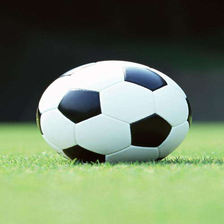

[805]
('n04254680', 'soccer_ball', 1.0)
('n04540053', 'volleyball', 7.697038e-09)
('n03445777', 'golf_ball', 2.4569324e-09)
('n04118538', 'rugby_ball', 7.4583717e-10)
('n02782093', 'balloon', 5.0675175e-10)


In [4]:
# 使用原视模型预测图片
%matplotlib inline
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
import numpy as np
from io import BytesIO
from IPython.display import display, HTML
from tensorflow.keras.applications.mobilenet import decode_predictions

IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_CHAnnels = 3

images = [
    "https://timgsa.baidu.com/timg?image&quality=80&size=b9999_10000&sec=1591705291052&di=23eab585eab52311827e5b84da0fd8ab&imgtype=0&src=http%3A%2F%2Fpic.baike.soso.com%2Fp%2F20130130%2F20130130200254-1391323912.jpg"
]

def make_square(img):
    cols, rows = img.size
    
    if rows > cols:
        pad = (rows - cols)/2
        img = img.crop((pad, 0, cols, cols))
    else:
        pad = (cols - rows)/2
        img = img.crop((0, pad, rows, rows))
        
    return img

for url in images:
    x = []
    ImageFile.LOAD_TRUNCATED_IMAGES = False
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img.load()
    img = img.resize((IMAGE_WIDTH, IMAGE_HEIGHT), Image.ANTIALIAS)
    
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    pred = model.predict(x)
    
    display(img)
    print(np.argmax(pred, axis=1))
    
    lst = decode_predictions(pred, top=5)
    for item in lst[0]:
        print(item)

In [5]:
# 训练模式
# import keras

# 加载原始模型（不包含分类层）
base_model = MobileNet(weights='imagenet', include_top=False)
# base_model.summary()

# 添加其他层
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # 添加密集的图层，以便模型可以学习更多复杂的特征并进行分类
x = Dense(1024, activation='relu')(x)
preds = Dense(2, activation='softmax')(x)  # 最后一层softmax作为激活函数

model = Model(inputs=base_model.input, outputs=preds)  # 指定输入输出，此时模型已经根据自己的架构创建完成

# 标记前20层可训练，其他层为不可训练
for layer in model.layers[:20]:
    layer.trainable = False
for layer in model.layers[20:]:
    layer.trainable = True
    
# 从文件夹中载入图像训练
"""
# 文件夹结构： ./train/class_A/1.jpg
                      /class_B/1.jpg
                      ...
"""
# 将数据加载到ImageDataGenerator中，指定路径，自动批量发送数据进行训练
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator = train_datagen.flow_from_directory('./datasets/flowers/train_data',
                                                 target_size=(224, 224),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 1376 images belonging to 2 classes.


In [28]:
# 训练模型
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy

step_size_train = train_generator.n//train_generator.batch_size
history = model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   epochs=4)

Epoch 1/4
43/43 [==============================] - 189s 4s/step - loss: 0.0585 - acc: 0.9789
Epoch 2/4
43/43 [==============================] - 217s 5s/step - loss: 0.0909 - acc: 0.9847
Epoch 3/4
43/43 [==============================] - 214s 5s/step - loss: 0.0384 - acc: 0.9906
Epoch 4/4
43/43 [==============================] - 213s 5s/step - loss: 0.1008 - acc: 0.9775


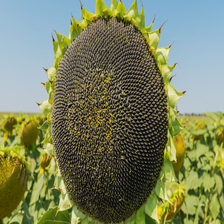

sunflower


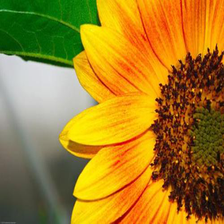

sunflower


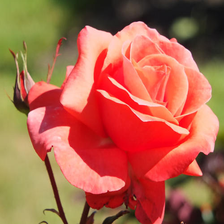

rose


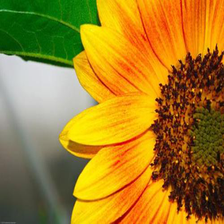

sunflower


In [29]:
# 使用训练好的模型预测图像
%matplotlib inline
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
import numpy as np
from io import BytesIO
from IPython.display import display, HTML
from tensorflow.keras.applications.mobilenet import decode_predictions

IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_CHANNELS = 3

images = [
    'https://ns-strategy.cdn.bcebos.com/ns-strategy/upload/fc_big_pic/part-00007-3606.jpg', 
    'https://ss1.bdstatic.com/70cFvXSh_Q1YnxGkpoWK1HF6hhy/it/u=2612260143,3924657332&fm=26&gp=0.jpg',
    'https://ss0.bdstatic.com/70cFvHSh_Q1YnxGkpoWK1HF6hhy/it/u=1652661266,3755002076&fm=26&gp=0.jpg',
    'https://ss1.bdstatic.com/70cFvXSh_Q1YnxGkpoWK1HF6hhy/it/u=2612260143,3924657332&fm=26&gp=0.jpg'
]

def make_square(img):
    cols, rows = img.size
    
    if rows > cols:
        pad = (rows - cols)/2
        img = img.crop((pad, 0, cols, cols))
    else:
        pad = (cols - rows)/2
        img = img.crop((0, pad, rows, rows))
        
    return img

classes_sorted = ['rose', 'sunflower']
for url in images:
    x = []
    ImageFile.LOAD_TRUNCATED_IMAGES = False
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img.load()
    img = img.resize((IMAGE_WIDTH, IMAGE_HEIGHT), Image.ANTIALIAS)
    
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    pred = model.predict(x)
    
    display(img)
    print(classes_sorted[np.argmax(pred, axis=1)[0]])

In [30]:
# 保存模型
model_dir = './modelzoo'
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
model.save(os.path.join(model_dir, 'classify_rose_and_sunflower_model.h5'))

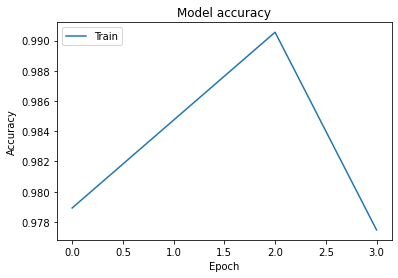

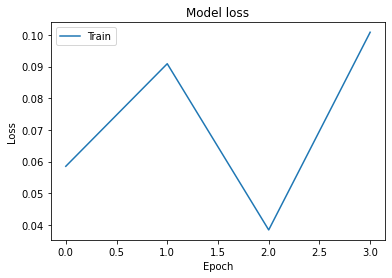

In [34]:
# 可视化训练过程
import matplotlib.pyplot as plt

# 绘制训练 & 验证的准确率值
plt.plot(history.history['acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# 绘制训练 & 验证的损失值
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [40]:
#  可视化模型结构
# from keras.utils import plot_model

# plot_model(model, to_file='model.png')